# Python & R Project - Video Games
### Authors: David Bauer, David Paquette, Filippo Navarra

## Import Libraries


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#For Word Analysis
from collections import Counter
import nltk
from nltk.corpus import stopwords

#Libraries for building & testing model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#IF NEED TO INSTALL
#%pip install statsmodels
import statsmodels.api as sm

# Libraries for Lasso Regression
from sklearn.linear_model import Lasso

## Import Dataset

In [2]:
### IMPORT DATASET

games = pd.read_csv('/Users/davidpaquette/Downloads/games.csv')

games.head() 

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


In [3]:
### ANALYZING DATASET

games.describe()
games.info(verbose = True)

games.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1512 non-null   int64  
 1   Title              1512 non-null   object 
 2   Release Date       1512 non-null   object 
 3   Team               1511 non-null   object 
 4   Rating             1499 non-null   float64
 5   Times Listed       1512 non-null   object 
 6   Number of Reviews  1512 non-null   object 
 7   Genres             1512 non-null   object 
 8   Summary            1511 non-null   object 
 9   Reviews            1512 non-null   object 
 10  Plays              1512 non-null   object 
 11  Playing            1512 non-null   object 
 12  Backlogs           1512 non-null   object 
 13  Wishlist           1512 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 165.5+ KB


(1512, 14)

In [4]:
# Getting some descriptive statistics 

games.describe()

,Unnamed: 0,Rating
count,1512.000000,1499.000000
mean,755.500000,3.719346
std,436.621117,0.532608
min,0.000000,0.700000
25%,377.750000,3.400000
50%,755.500000,3.800000
75%,1133.250000,4.100000
max,1511.000000,4.800000


In [5]:
# Null Values

games.isnull().sum()

Unnamed: 0            0
Title                 0
Release Date          0
Team                  1
Rating               13
Times Listed          0
Number of Reviews     0
Genres                0
Summary               1
Reviews               0
Plays                 0
Playing               0
Backlogs              0
Wishlist              0
dtype: int64

In [6]:
# Duplicated values
games.duplicated().any()

False

## Cleaning Dataset

In [7]:
# Duplicated Games

dup_games = games.duplicated(subset = 'Title')

games = games.drop(games[dup_games].index)


In [8]:
# Drop extra index column and summary and reviews since performing text analysis is outside the scope of this project
games_v2 = games.drop(columns = ['Unnamed: 0', 'Summary']) 

# Create Dataframe to be used for analysis of text columns - will have same cleaning process, except includes
# variables of string datatype
games_words = games.drop(columns = ['Unnamed: 0'])

# Drop nulls
games_clean = games_v2.dropna() 
games_words = games_words.dropna()

In [9]:
# Number of reviews and times listed convey the same information
games_clean = games_clean.drop(["Times Listed"],axis = 1)
games_words = games_words.drop(["Times Listed"],axis = 1)

In [10]:
# Function to convert columns from k values to values in thousands.

def k_to_int(value):
    """
    Converts string values into integers the represent.

    Parameters
    ----------
    value : string
        String value that represent an integer.

    Returns
    -------
    Integer.
    
    Example
    -------
    > k_to_int(3.9k)
    > 3900

    """
    if 'k' or 'K' in value:      
        value = value.replace('K', '').replace('k', '')      
        if '.' in value:          
            return int(float(value) * 1000)  
        else:   
            return int(value) * 1000        
    else:       
        return int(value)

In [11]:
# Converting k values

k_columns = ['Number of Reviews', 'Plays', 'Playing', 'Backlogs', 'Wishlist']

games_clean[k_columns] = games_clean[k_columns].applymap(k_to_int)
games_words[k_columns] = games_words[k_columns].applymap(k_to_int)

In [12]:
## Looking at Release Dates

unique_dates = games_clean['Release Date'].value_counts()
print(unique_dates)

games_clean.loc[games_clean['Release Date'] == 'releases on TBD']
games_words.loc[games_words['Release Date'] == 'releases on TBD']

Nov 12, 2020    5
Sep 26, 2013    3
Nov 18, 2016    3
Nov 11, 2014    3
Dec 22, 2005    3
               ..
Jan 30, 2004    1
Mar 21, 2014    1
Jul 29, 2010    1
Sep 26, 2017    1
Nov 17, 2008    1
Name: Release Date, Length: 961, dtype: int64


,Title,Release Date,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
644,Deltarune,releases on TBD,['tobyfox'],4.3,313000,"['Adventure', 'Indie', 'Music', 'Puzzle', 'RPG']","UNDERTALE's parallel story, DELTARUNE. Meet ne...","['Spamton is so hot, I want to kiss him in the...",1300,83000,468000,617000
1252,Elden Ring: Shadow of the Erdtree,releases on TBD,"['FromSoftware', 'Bandai Namco Entertainment']",4.8,18000,"['Adventure', 'RPG']",An expansion to Elden Ring setting players on ...,['I really loved that they integrated Family G...,1000,0,39000,146000


In [13]:
# Remove rows with "release in TBD" as Release Date value

games_clean = games_clean.loc[games_clean['Release Date'] != 'releases on TBD']
games_words = games_words.loc[games_words['Release Date'] != 'releases on TBD']

In [14]:
# Transforming 'Release Date' column into datetime format

games_clean['Release Date'] = pd.to_datetime(games_clean['Release Date'], format='%b %d, %Y')
games_words['Release Date'] = pd.to_datetime(games_words['Release Date'], format='%b %d, %Y')

# Creating function that adds column with season game was released in

def get_season(date):
    """
    Takes a date as an input and returns the season of the date

    Parameters
    ----------
    date : TYPE
        DESCRIPTION.

    Returns
    -------
    str
        DESCRIPTION.

    """
    
    month = date.month
    
    if 3 <= month <= 5:return 'Spring'
    elif 6 <= month <= 8: return 'Summer'
    elif 9 <= month <= 11:return 'Fall'
    else: return'Winter'

# Adding columns with respective season, month, and year game was released in
# Also, removing the 'Release Data' column as no longer useful

games_clean['Season'] = games_clean['Release Date'].apply(get_season)
games_clean['Release Month'] = games_clean['Release Date'].dt.strftime('%b')
games_clean['Release Year'] = games_clean['Release Date'].dt.year

games_clean.drop('Release Date', axis=1, inplace=True)

games_words['Season'] = games_words['Release Date'].apply(get_season)
games_words['Release Month'] = games_words['Release Date'].dt.strftime('%b')
games_words['Release Year'] = games_words['Release Date'].dt.year

games_words.drop('Release Date', axis=1, inplace=True)

In [15]:
# Columns Genres & Team are illustrated as lists, but datatype shows that they are strings meaning the
# square brackets ([]), and apostrophes are strings - Therefore need to change datatype because stripping 
# string of list elements doesn't work well. For example, would split B.B. Studio into 3 different teams('B', 'B', 'Studio')
# Also needed way to keep spaces in company name to avoid condensation of names (i.e. BandaiNamco -> Bandai Namco)

# Function to convert column to from string to list
def convert_to_list(string_list):
    
    # Using ast.literal_eval to safely evaluate the string as a literal expression
    return ast.literal_eval(string_list)

games_clean['Genres'] = games_clean['Genres'].apply(convert_to_list)
games_clean['Team'] = games_clean['Team'].apply(convert_to_list)
games_words['Reviews'] = games_words['Reviews'].apply(convert_to_list)

In [16]:
# Initiate dictionary to track the the number of video games per genre
genres_dict = {}

# Iterate through the 'Genres' column
for genre_list in games_clean['Genres']:
    
    # Iterate through individual genres in the list
    for genre in genre_list:
        
        if genre != '':
            if genre in genres_dict:
                genres_dict[genre] += 1
            else:
                genres_dict[genre] = 1

#Same logic for Teams column
team_dict = {}
    
# Iterate through the 'Team' column
for team_list in games_clean['Team']:    
    
    # Iterate through individual teams in the list
    for team in team_list:
        # In case of empty space before name of team
        if team[0] == ' ': 
            team = team[1:]
        if team != '':
            if team in team_dict:
                team_dict[team] += 1
            else:
                team_dict[team] = 1

In [17]:
#View number unique Teams
print(len(team_dict))

655


## Bag of Words

In [18]:
# An attempt to use a bag of words aproach to identify if the review text has specific sentients potentially 
# impacting the rating

# getting a bag-of-words representation using CountVectorizer
vec = CountVectorizer()
bag = vec.fit_transform(games_clean['Reviews'])

# use k-means clustering
clusters = 2 
k_means = KMeans(n_clusters = clusters, random_state=30)
games_clean['Sentiment'] = k_means.fit_predict(bag)

In [19]:
games_clean.head()

,Title,Team,Rating,Number of Reviews,Genres,Reviews,Plays,Playing,Backlogs,Wishlist,Season,Release Month,Release Year,Sentiment
0,Elden Ring,"[Bandai Namco Entertainment, FromSoftware]",4.5,3900,"[Adventure, RPG]","[""The first playthrough of elden ring is one o...",17000,3800,4600,4800,Winter,Feb,2022,0
1,Hades,[Supergiant Games],4.3,2900,"[Adventure, Brawler, Indie, RPG]",['convinced this is a roguelike for people who...,21000,3200,6300,3600,Winter,Dec,2019,1
2,The Legend of Zelda: Breath of the Wild,"[Nintendo, Nintendo EPD Production Group No. 3]",4.4,4300,"[Adventure, RPG]",['This game is the game (that is not CS:GO) th...,30000,2500,5000,2600,Spring,Mar,2017,0
3,Undertale,"[tobyfox, 8-4]",4.2,3500,"[Adventure, Indie, RPG, Turn Based Strategy]",['soundtrack is tied for #1 with nier automata...,28000,679000,4900,1800,Fall,Sep,2015,0
4,Hollow Knight,[Team Cherry],4.4,3000,"[Adventure, Indie, Platform]","[""this games worldbuilding is incredible, with...",21000,2400,8300,2300,Winter,Feb,2017,1


## Updating DataFrame Name

In [20]:
games = games_clean

## Exploratory Data Analysis

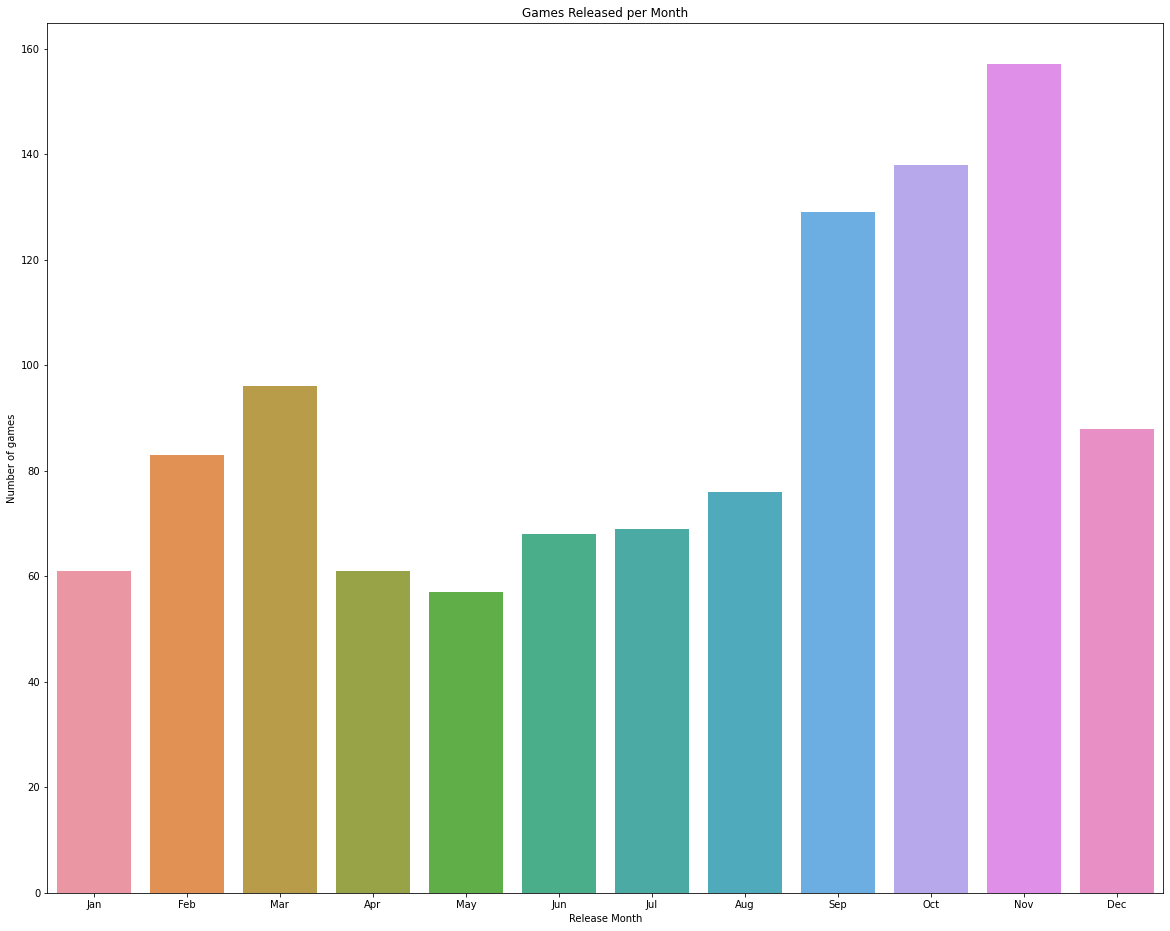

In [21]:
# GAMES PER MONTH

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create DataFrame where number of games is grouped by months
games_per_month = games.groupby('Release Month').size().reindex(months)
games_per_month = pd.DataFrame({'Release Month': months, 'Number of Games': games_per_month.values})
plt.figure(figsize = (20,16))
plt.title('Games Released per Month')
sns.barplot(data = games_per_month, x = 'Release Month' , y = 'Number of Games')
plt.xlabel('Release Month')
plt.ylabel('Number of games')

plt.show()

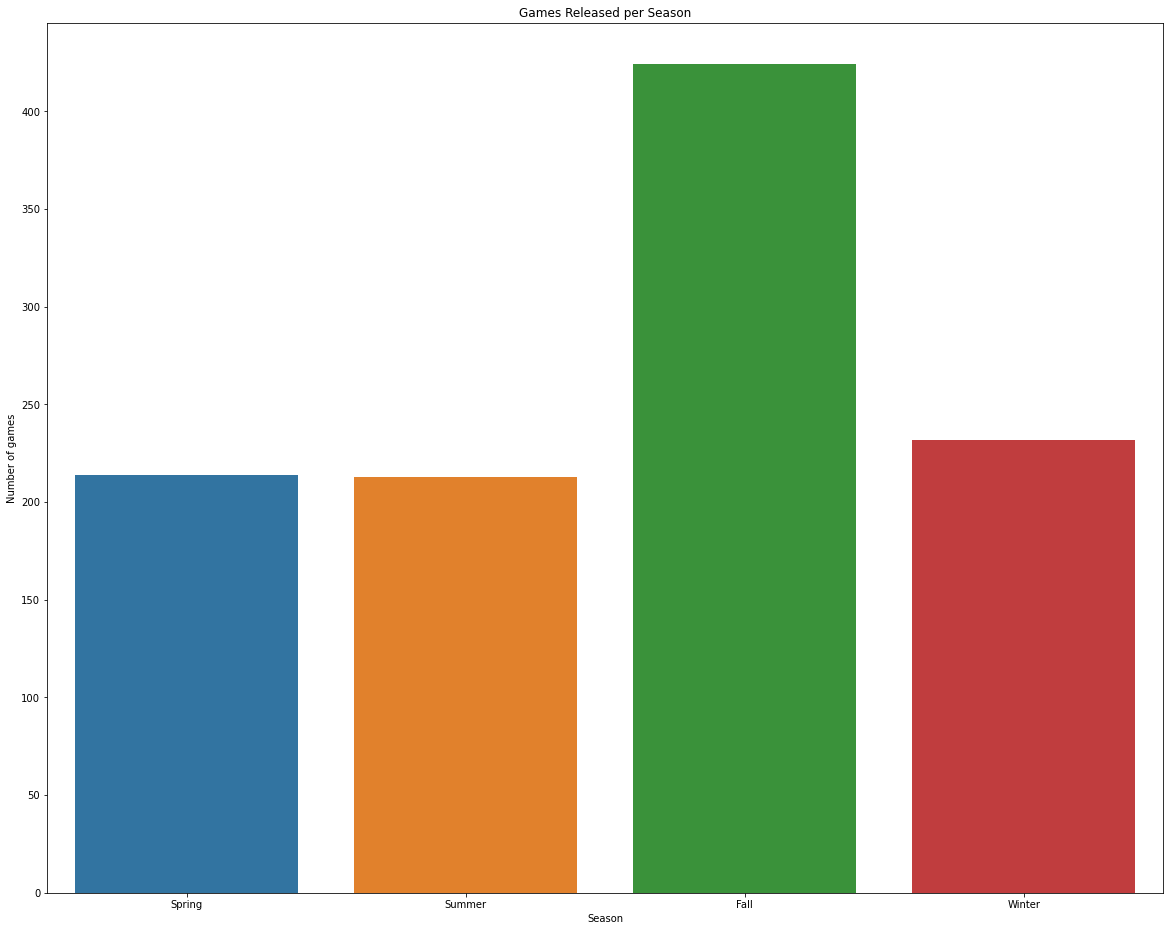

In [22]:
# GAMES PER SEASON


seasons = ['Spring', 'Summer', 'Fall', 'Winter']
games_per_season = games.groupby('Season').size().reindex(seasons)

# Create DataFrame where number of games is grouped by season
games_per_season = pd.DataFrame({'Season': seasons, 'Number of Games': games_per_season.values})
plt.figure(figsize = (20, 16))
plt.title('Games Released per Season')
sns.barplot(data = games_per_season, x ='Season', y = 'Number of Games')
plt.xlabel('Season')
plt.ylabel('Number of games')

plt.show()

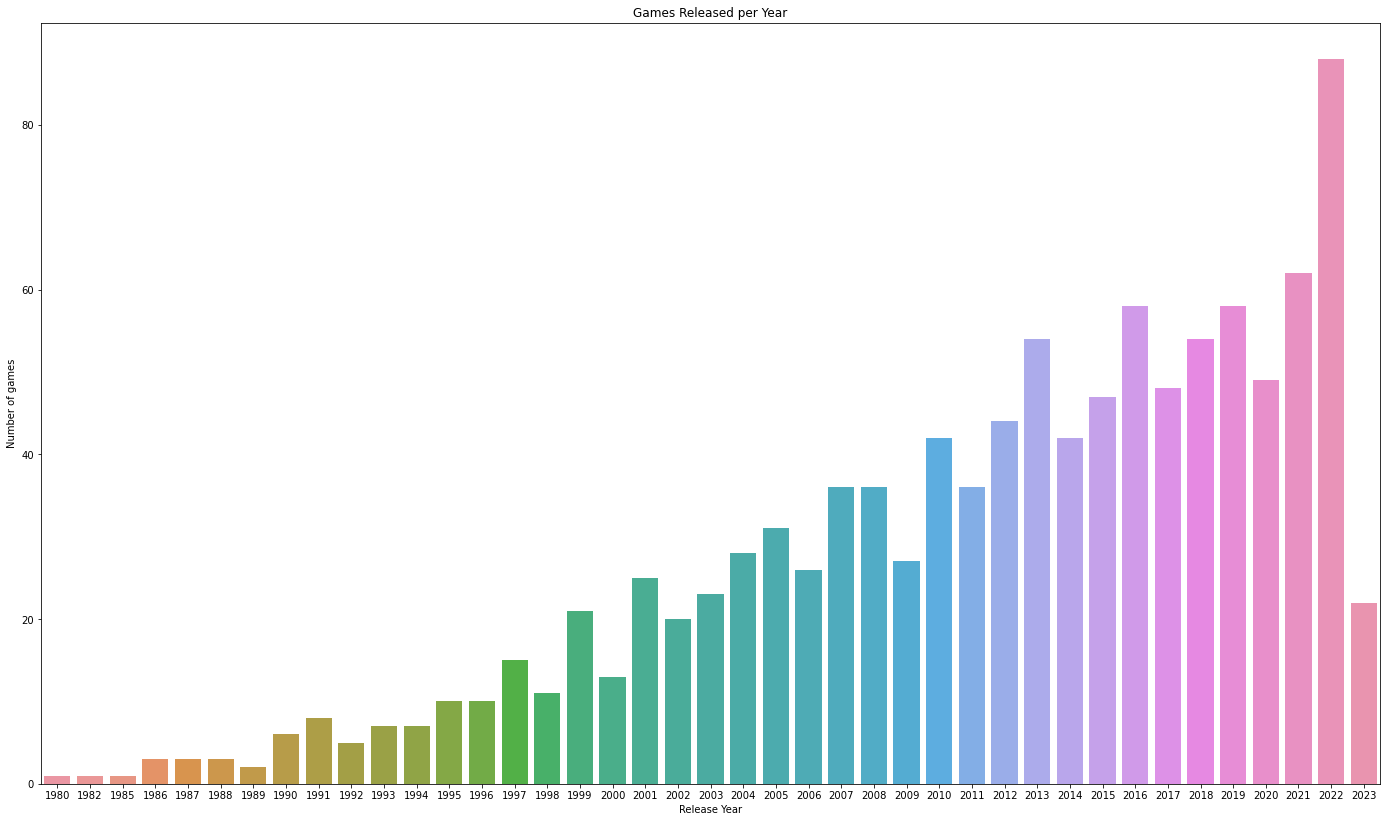

In [23]:
### GAMES PER YEAR

# Create DataFrame where number of games is grouped by year
games_per_year = games['Release Year'].value_counts().reset_index()
games_per_year.columns = ['Release Year', 'Number of Games']
plt.figure(figsize = (24, 14))
plt.title('Games Released per Year')
sns.barplot(data = games_per_year, x ='Release Year', y = 'Number of Games')
plt.xlabel('Release Year')
plt.ylabel('Number of games')

plt.show()

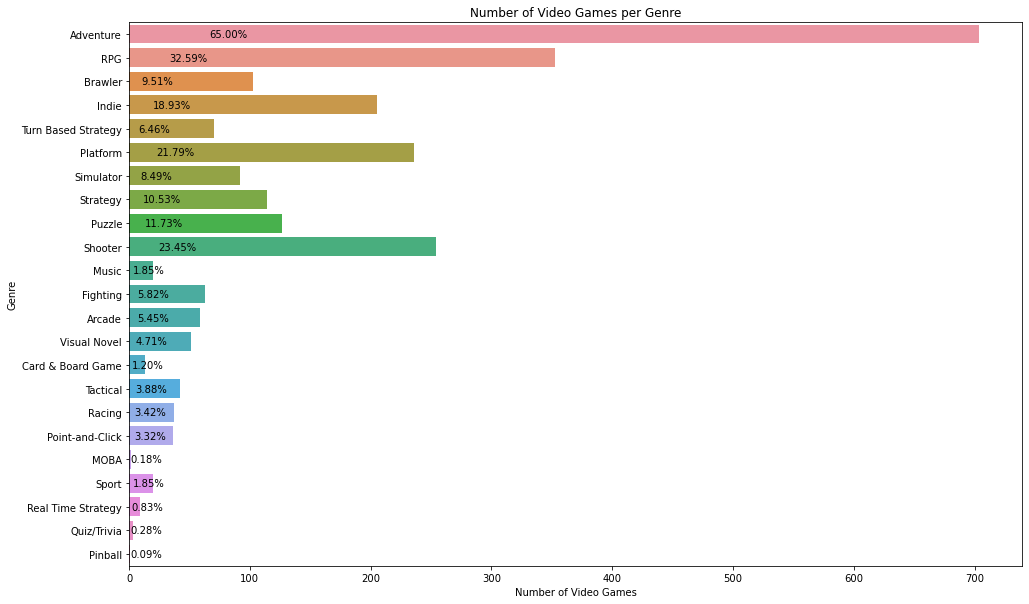

In [24]:
### TOTAL GENRES

# Percentage of games belonging to certain genre
perc = [(j / len(games)) * 100 for j in genres_dict.values()] #new line

# Create lists
genres_list = list(genres_dict.keys())
genres_count_list = list(genres_dict.values())

# Create DataFrame with number of video games and genres
df_genres = pd.DataFrame({'Genre': genres_list, 'Number of Video Games': genres_count_list})
plt.figure(figsize = (16, 10))
sns.barplot(data = df_genres, x = 'Number of Video Games', y = 'Genre', orient = 'horizontal')
plt.xlabel('Number of Video Games')
plt.ylabel('Genre')
plt.title('Number of Video Games per Genre')

# Add percentage as text in plot
for i, val in enumerate(perc): 
    plt.text(val + 1, i, f'{val:.2f}%', va='center')
    
plt.show()

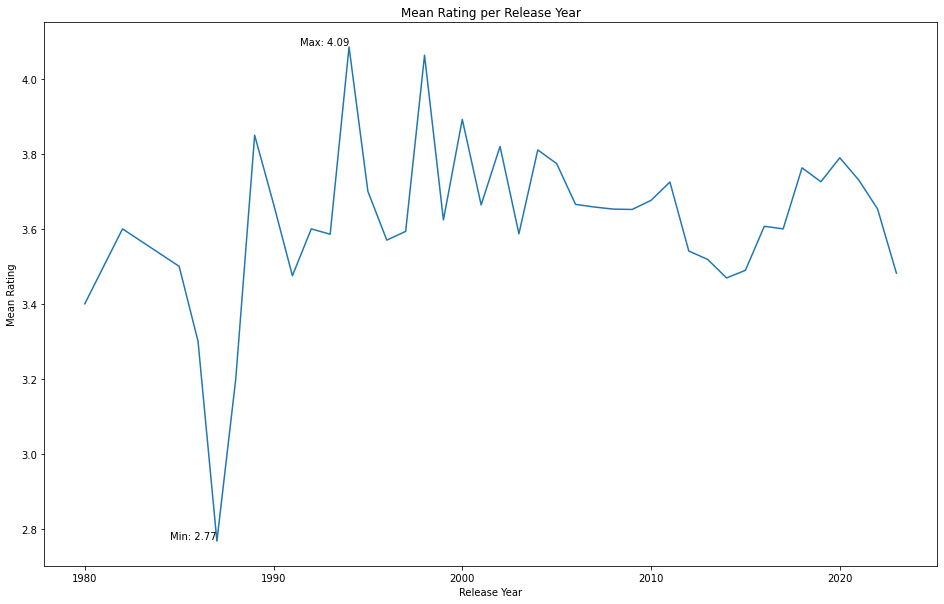

In [25]:
### MEAN RATING PER YEAR

df_mean_ratings = games.groupby('Release Year')['Rating'].mean().reset_index().sort_values('Release Year')

plt.figure(figsize = (16,10))

sns.lineplot(data = df_mean_ratings, x = 'Release Year', y = 'Rating')

plt.title('Mean Rating per Release Year')

# Finding indices of min and max ratings
min_index = df_mean_ratings['Rating'].idxmin()
max_index = df_mean_ratings['Rating'].idxmax()

# Adding text for min and max values
min_rating = df_mean_ratings.loc[min_index, 'Rating']
max_rating = df_mean_ratings.loc[max_index, 'Rating']

plt.text(df_mean_ratings.loc[min_index, 'Release Year'], min_rating, f'Min: {min_rating:.2f}', ha='right', va='bottom', color='black')
plt.text(df_mean_ratings.loc[max_index, 'Release Year'], max_rating, f'Max: {max_rating:.2f}', ha='right', va='bottom', color='black')

plt.xlabel('Release Year')

plt.ylabel('Mean Rating')

plt.show()

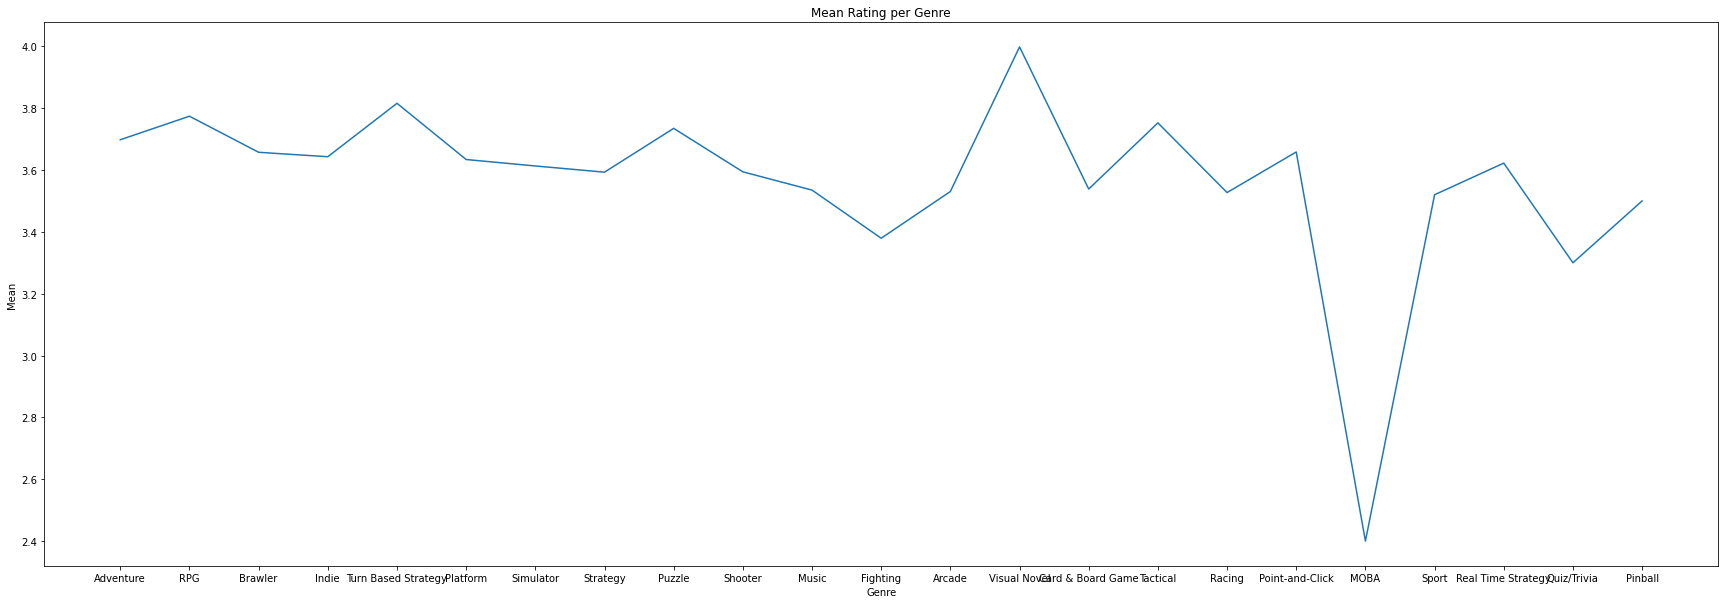

In [26]:
### MEAN RATING PER GENRE

# Initiate dictionary that will contain genres as keys and mean rating as value
genre_ratings = {}

# Iterate through dictionary
for genre in genres_dict:
    
    tot_games = genres_dict[genre]
    
    sum_rating = 0
    
    # Iterate through dataframe
    for index,rows in games.iterrows():
        
        if genre in rows['Genres']:
            
            sum_rating += rows['Rating']
            
    avg_rating = sum_rating / tot_games
    
    genre_ratings[genre] = avg_rating
        
df_genre_ratings = pd.DataFrame({'Genre': genre_ratings.keys(), 'Mean Rating': genre_ratings.values()})

plt.figure(figsize = (30,10))

sns.lineplot(data = df_genre_ratings, x = 'Genre', y = 'Mean Rating')

plt.title('Mean Rating per Genre')

plt.xlabel('Genre')

plt.ylabel('Mean')

plt.show()

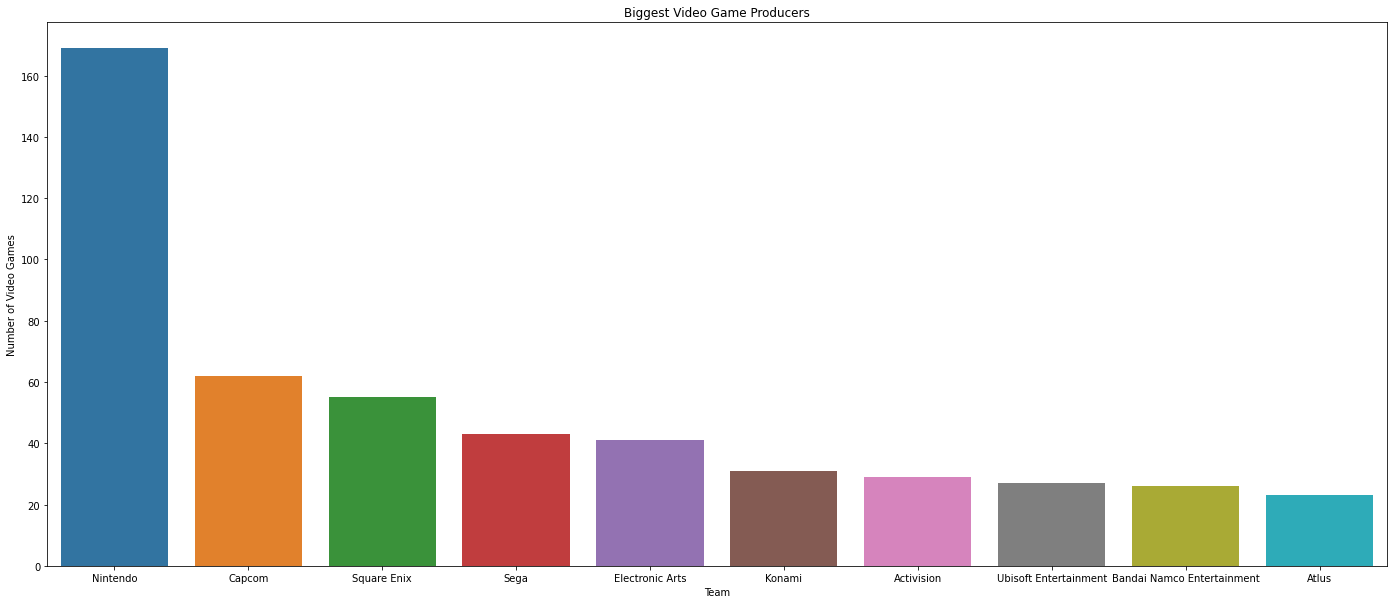

In [27]:
### NUMBER OF GAMES PRODUCED BY TEAMS

team_list = list(team_dict.keys())
team_count_list = list(team_dict.values())

df_teams = pd.DataFrame({'Team' : team_list, 'Number of Video Games' : team_count_list})

# Filter for top 10 game producing teams based on quantity
most_games_teams = df_teams.nlargest(10, 'Number of Video Games')
plt.figure(figsize = (24, 10))
sns.barplot(data = most_games_teams, x = 'Team', y = 'Number of Video Games')
plt.xlabel('Team')
plt.ylabel('Number of Video Games')
plt.title('Biggest Video Game Producers')

plt.show()

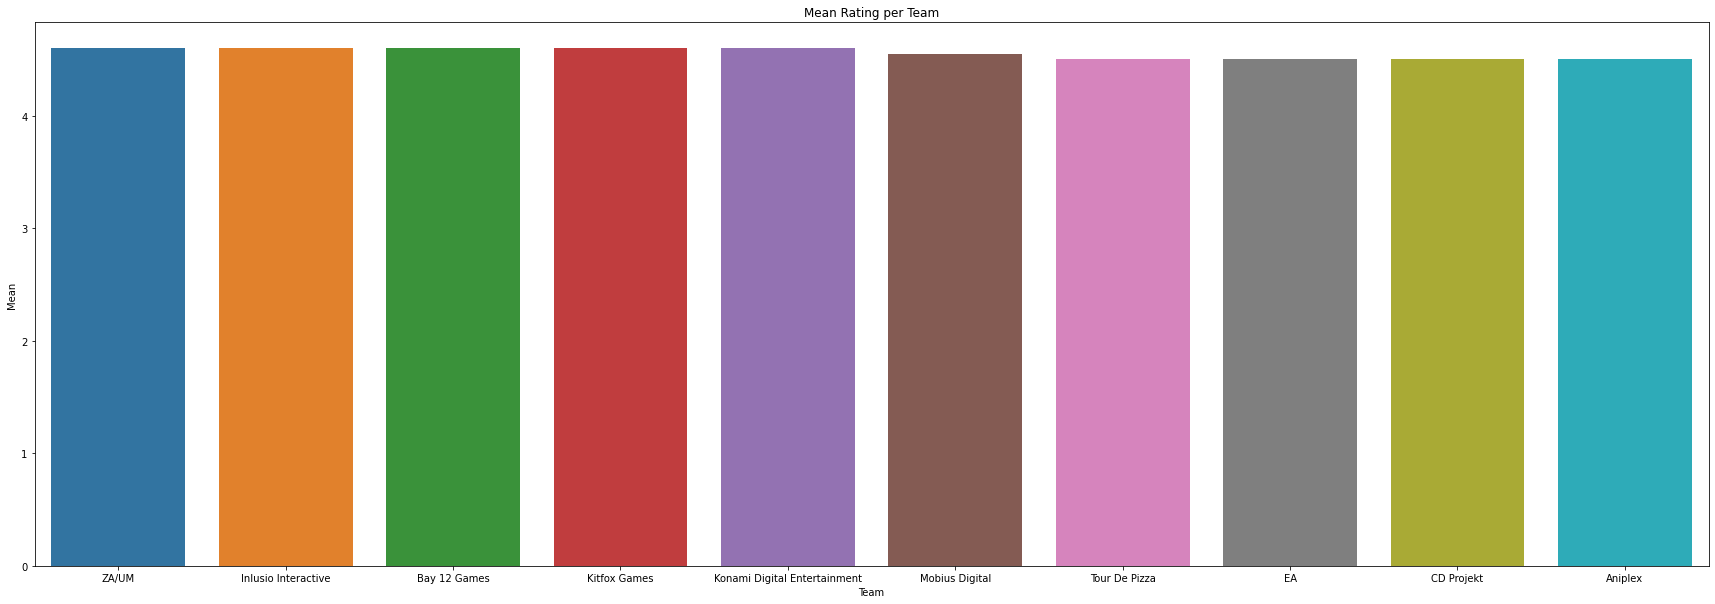

In [28]:
### MEAN VIDEO GAME RATING BY TEAM

team_ratings = {}

for team in team_dict:
    tot_games = team_dict[team]
    sum_rating = 0
    
    for index,rows in games.iterrows():    
        if team in rows['Team']:  
            sum_rating += rows['Rating']
            
    avg_rating = sum_rating / tot_games
    team_ratings[team] = round(avg_rating, 2)
        
df_team_ratings = pd.DataFrame({'Team': team_ratings.keys(), 'Mean Rating': team_ratings.values()})
top_10_team_ratings = df_team_ratings.nlargest(10, 'Mean Rating')

plt.figure(figsize = (30,10))
sns.barplot(data = top_10_team_ratings, x = 'Team', y = 'Mean Rating')
plt.title('Mean Rating per Team')
plt.xlabel('Team')
plt.ylabel('Mean')

plt.show()

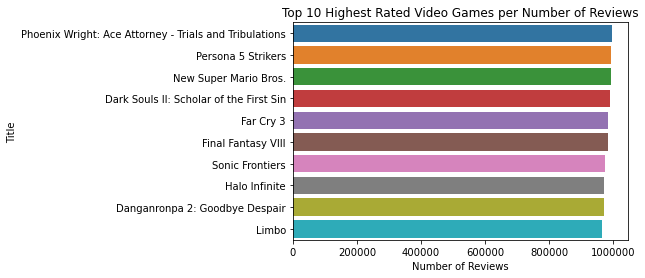

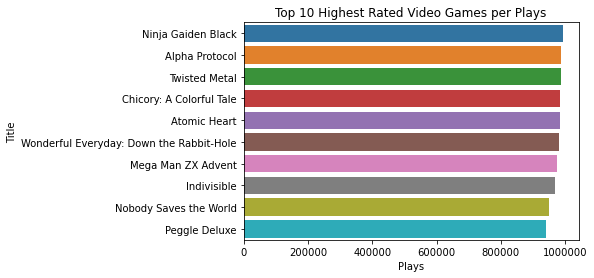

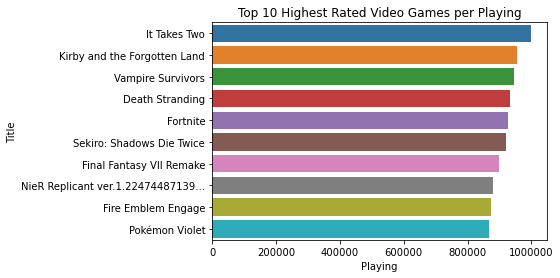

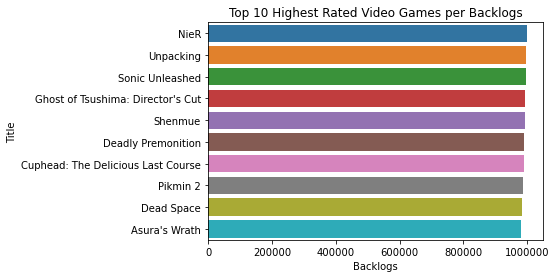

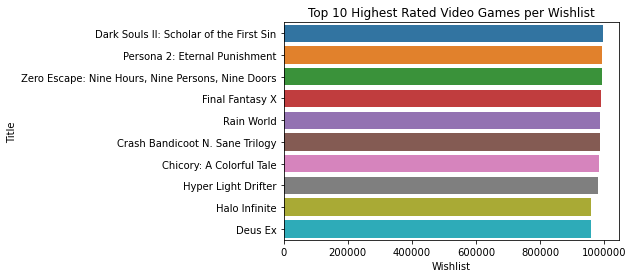

In [29]:
### ANALYZING K COLUMNS - TOP 10 PER COLUMN

for col in k_columns:
    
    df_top_x = games.nlargest(10, col)
    sns.barplot(data = df_top_x, x = col , y = 'Title')
    plt.title('Top 10 Highest Rated Video Games per '+col)
    plt.xlabel(col)
    plt.ylabel('Title') 
    plt.ticklabel_format(style='plain', axis='x')

    plt.show()

## Exploratory Data Anlysis -  Nintendo
Nintendo produced most video games, decided to analyze the team further

In [30]:
# Create new DataFrame with only Nintendo

nintendo = games[games['Team'].apply(lambda x: 'Nintendo' in x)]

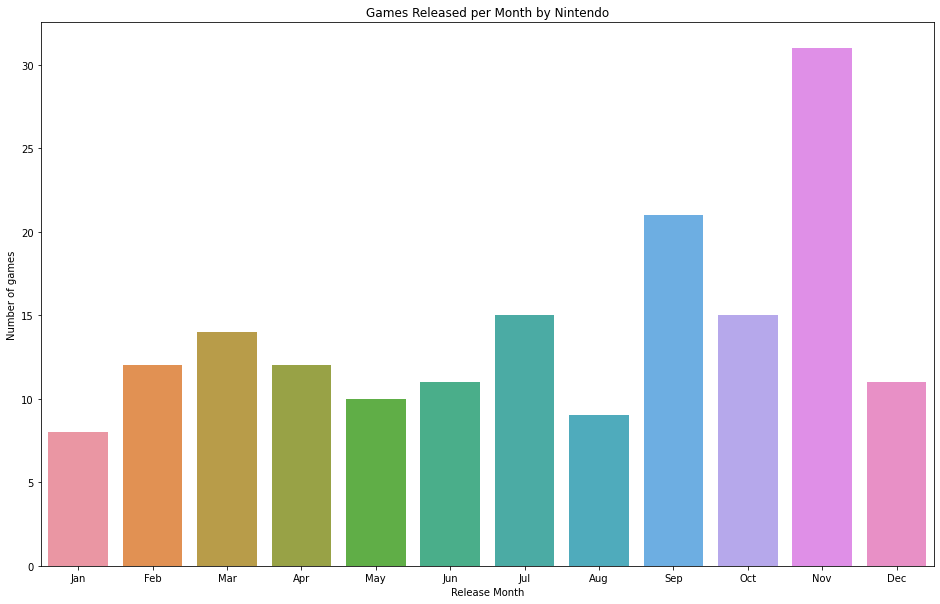

In [31]:
# Nintendo per Month 

nintendo_per_month = nintendo.groupby('Release Month').size().reindex(months)
nintendo_per_month = pd.DataFrame({'Release Month': months, 'Number of Games': nintendo_per_month.values})

plt.figure(figsize = (16, 10))

plt.title('Games Released per Month by Nintendo')

sns.barplot(data = nintendo_per_month, x = 'Release Month' , y = 'Number of Games')

plt.xlabel('Release Month')

plt.ylabel('Number of games')

plt.show()

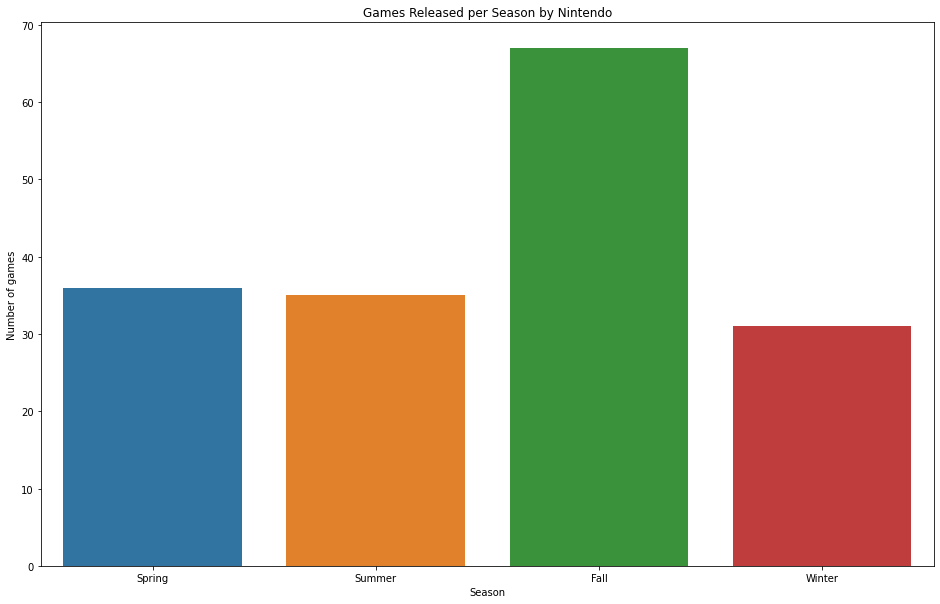

In [32]:
### NINTENDO GAMES PRODUCED PER SEASON

nintendo_per_season = nintendo.groupby('Season').size().reindex(seasons)
nintendo_per_season = pd.DataFrame({'Season': seasons, 'Number of Games': nintendo_per_season.values})

plt.figure(figsize = (16, 10))

plt.title('Games Released per Season by Nintendo')

sns.barplot(data = nintendo_per_season, x ='Season', y = 'Number of Games')

plt.xlabel('Season')

plt.ylabel('Number of games')

plt.show()

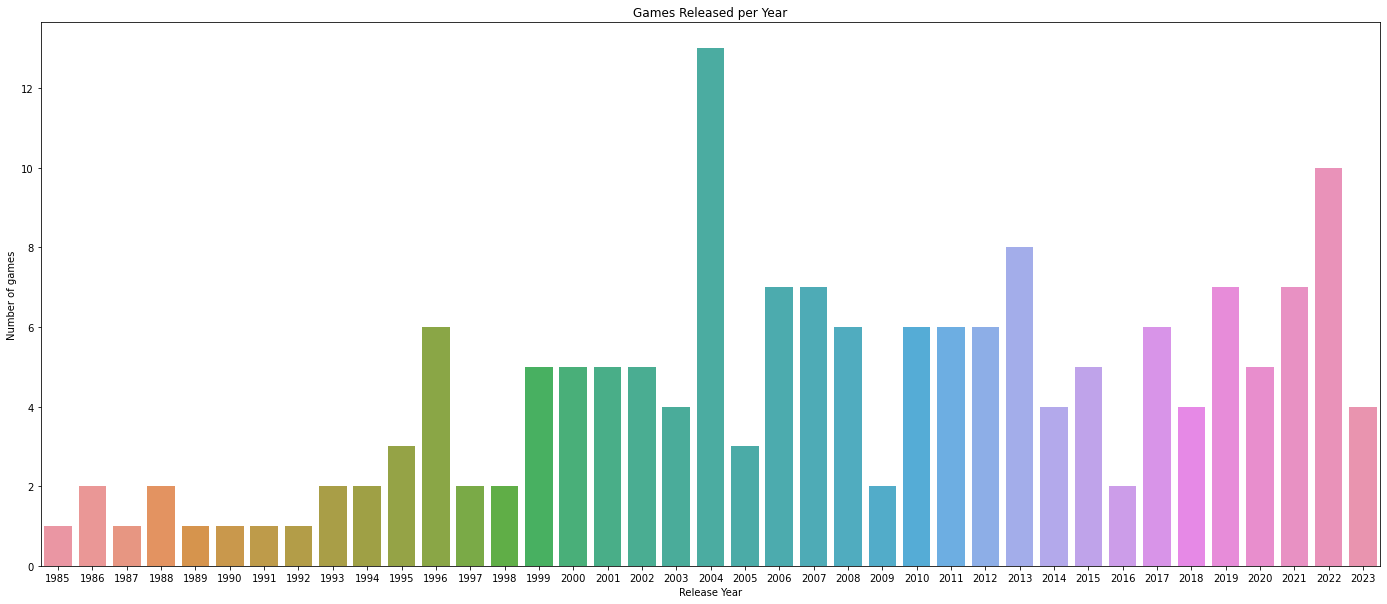

In [33]:
# Nintendo Per Year

# Group by Release Year
nintendo_per_year = nintendo['Release Year'].value_counts().reset_index().sort_values('Release Year')
nintendo_per_year.columns = ['Release Year', 'Number of Games']

plt.figure(figsize = (24, 10))
plt.title('Games Released per Year')
sns.barplot(data = nintendo_per_year, x ='Release Year', y = 'Number of Games')
plt.xlabel('Release Year')
plt.ylabel('Number of games')

plt.show()

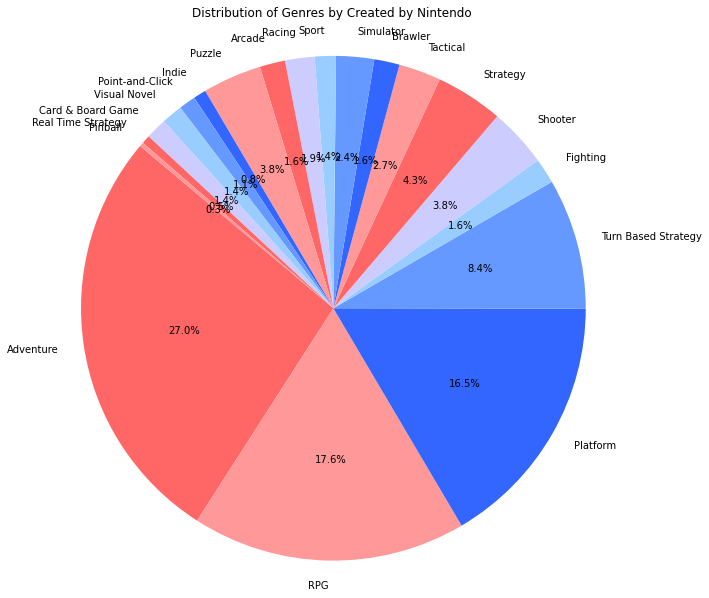

In [34]:
### NINTENDO GAMES PRODUCED PER GENRE

nintendo_genres_dict = {}

# Iterate through the 'Genres' column
for nintendo_genre_list in nintendo['Genres']:
   
    # Iterate through individual genres in the list
    for genre in nintendo_genre_list:
        
        if genre != '':
            if genre in nintendo_genres_dict:
                nintendo_genres_dict[genre] += 1
            else:
                nintendo_genres_dict[genre] = 1

nintendo_genres_list = list(nintendo_genres_dict.keys())
nintendo_genres_count_list = list(nintendo_genres_dict.values())

df_nintendo_genres = pd.DataFrame({'Genre': nintendo_genres_list, 'Number of Video Games': nintendo_genres_count_list})
df_nintendo_genres['Percentage'] = ((df_nintendo_genres['Number of Video Games'] / df_nintendo_genres['Number of Video Games'].sum()) * 100)
plt.figure(figsize = (10,10))
patches, texts, autotexts = plt.pie(df_nintendo_genres['Number of Video Games'], labels = df_nintendo_genres['Genre'], autopct='%1.1f%%', startangle=140, colors = ['#FF6666', '#FF9999', '#3366FF', '#6699FF', '#99CCFF', '#CCCCFF'])
plt.axis('equal')

for autotext in autotexts: 
    autotext.set_text(f'{autotext.get_text()}')

plt.title('Distribution of Genres by Created by Nintendo', pad=20)

plt.show()

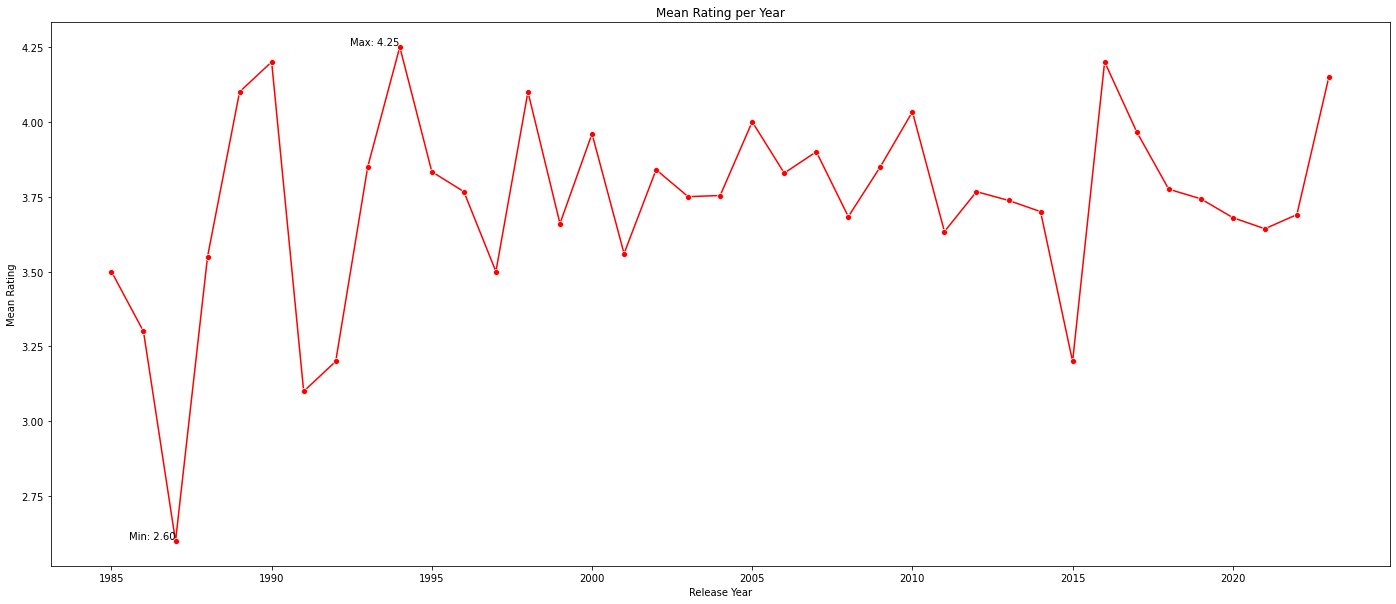

In [35]:
### NINTENDO MEAN RATING PER YEAR
mean_rating_per_year = nintendo.groupby('Release Year')['Rating'].mean().reset_index().sort_values('Release Year')

plt.figure(figsize = (24, 10))
plt.title('Mean Rating per Year')
sns.lineplot(data = mean_rating_per_year, x = 'Release Year', y = 'Rating', color ='red', marker = 'o')

# Finding indices for min and max ratings
min_index = mean_rating_per_year['Rating'].idxmin()
max_index = mean_rating_per_year['Rating'].idxmax()

# Adding text for min and max values
min_rating = mean_rating_per_year.loc[min_index, 'Rating']
max_rating = mean_rating_per_year.loc[max_index, 'Rating']

plt.text(mean_rating_per_year.loc[min_index, 'Release Year'], min_rating, f'Min: {min_rating:.2f}', ha='right', va='bottom', color='black')
plt.text(mean_rating_per_year.loc[max_index, 'Release Year'], max_rating, f'Max: {max_rating:.2f}', ha='right', va='bottom', color='black')
plt.xlabel('Release Year')
plt.ylabel('Mean Rating')

plt.show()

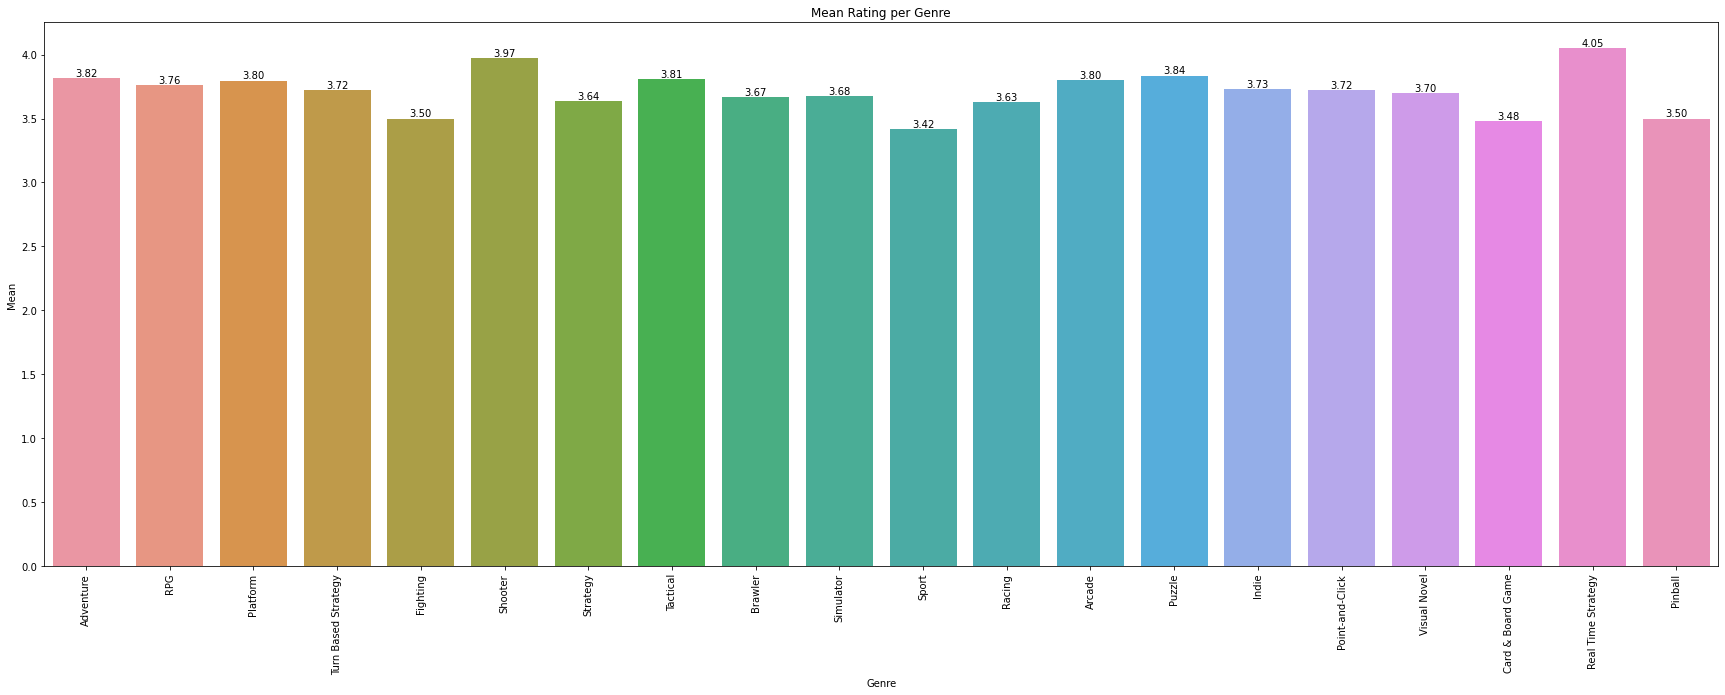

In [36]:
### NINTENDO MEAN RATING PER GENRE

nintendo_genre_ratings = {}

for genre in nintendo_genres_dict:
    tot_games = nintendo_genres_dict[genre]
    sum_rating = 0
    
    for index,rows in nintendo.iterrows():
        
        if genre in rows['Genres']:   
            sum_rating += rows['Rating']
            
    avg_rating = sum_rating / tot_games
    nintendo_genre_ratings[genre] = avg_rating
        
df_nintendo_genre_ratings = pd.DataFrame({'Genre': nintendo_genre_ratings.keys(), 'Mean Rating': nintendo_genre_ratings.values()})

plt.figure(figsize = (30,10))
sns.barplot(data = df_nintendo_genre_ratings, x = 'Genre', y = 'Mean Rating')
plt.title('Mean Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Mean')

# In order to add text

for index, row in df_nintendo_genre_ratings.iterrows():
    plt.text(index, row['Mean Rating'], f'{row["Mean Rating"]:.2f}', color='black', ha="center", va="bottom")
    
plt.xticks(rotation=90) 

plt.show()

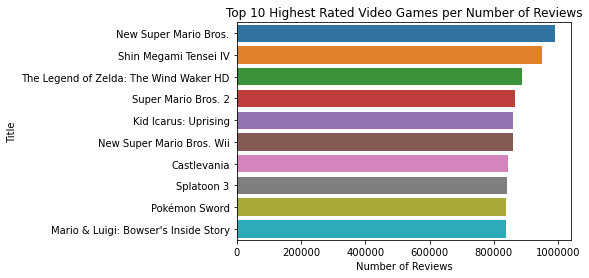

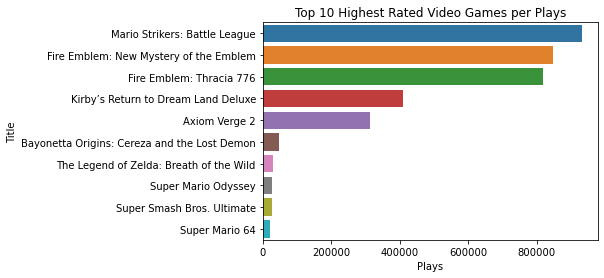

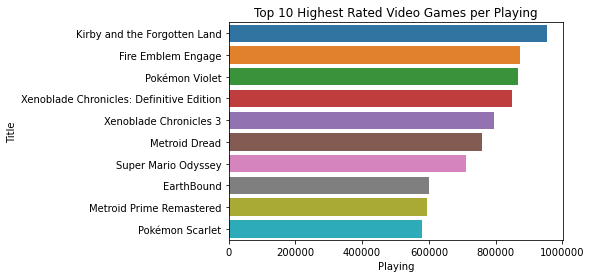

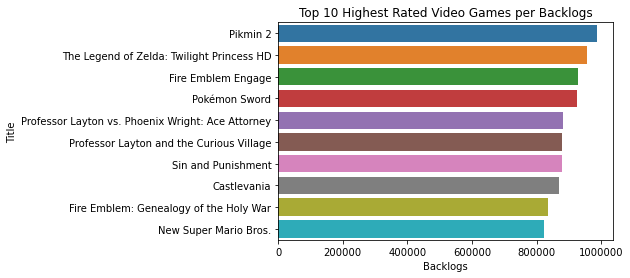

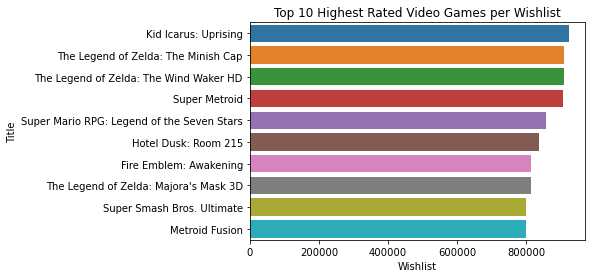

In [37]:
### ANALYZING K COLUMNS - TOP 10 PER COLUMN FOR NINTENDO

for col in k_columns:
    
    df_top_x = nintendo.nlargest(10, col)
    
    sns.barplot(data = df_top_x, x = col , y = 'Title')

    plt.title('Top 10 Highest Rated Video Games per '+col)

    plt.xlabel(col)

    plt.ylabel('Title')
    
    plt.ticklabel_format(style='plain', axis='x')

    plt.show()

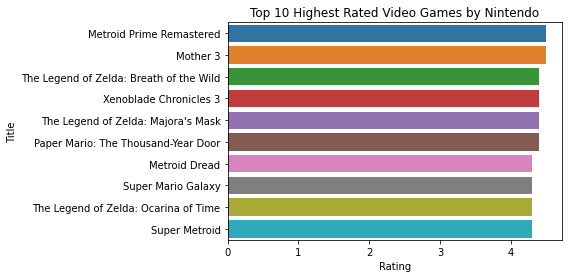

In [38]:
### HIGHEST RATED NINTENDO GAMES

nintendo_top_10_ratings = nintendo.nlargest(10, 'Rating')

sns.barplot(data = nintendo_top_10_ratings, x = 'Rating', y = 'Title')

plt.title('Top 10 Highest Rated Video Games by Nintendo')

plt.xlabel('Rating')

plt.ylabel('Title')

plt.show()

### Violin Boxplots

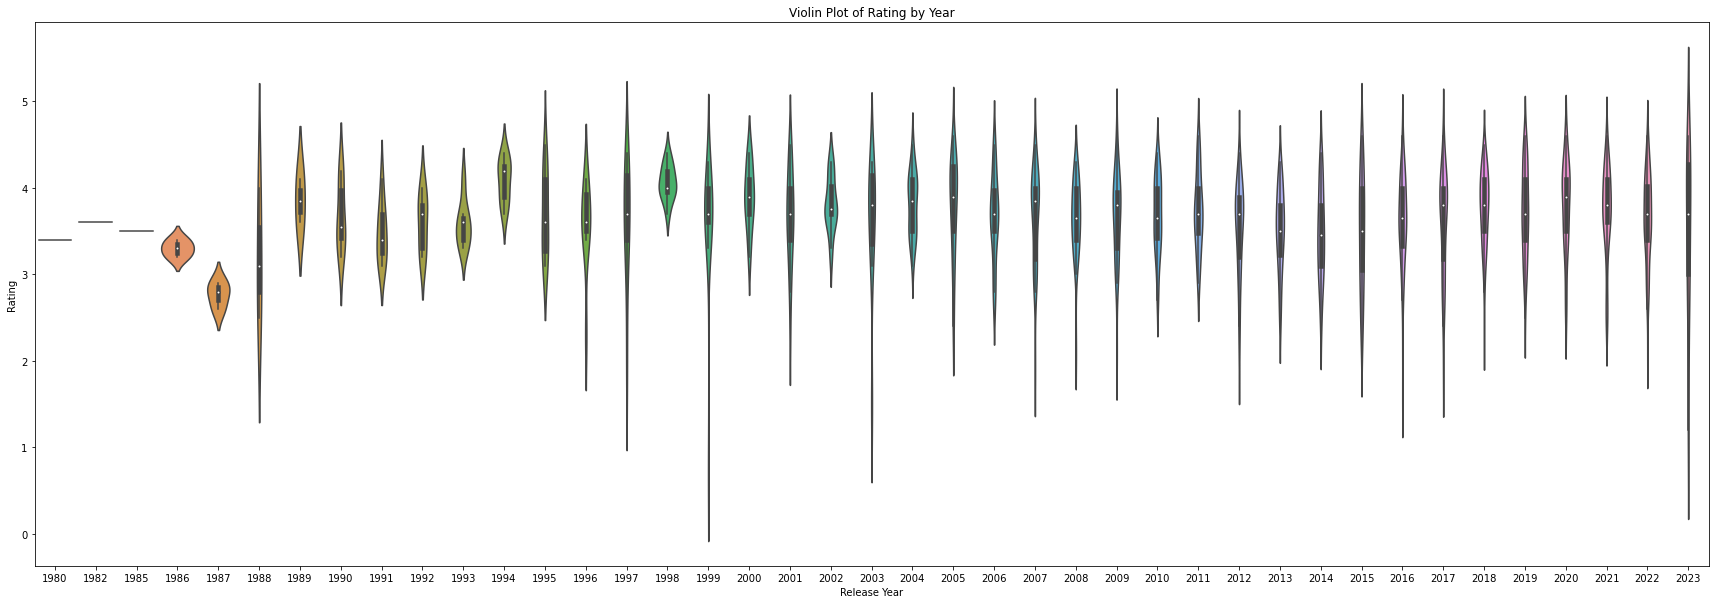

In [39]:
### YEAR & RATING

plt.figure(figsize = (30, 10))

sns.violinplot(x = 'Release Year', y = 'Rating', data = games)

plt.title('Violin Plot of Rating by Year')

plt.xlabel('Release Year')

plt.ylabel('Rating')

plt.show()

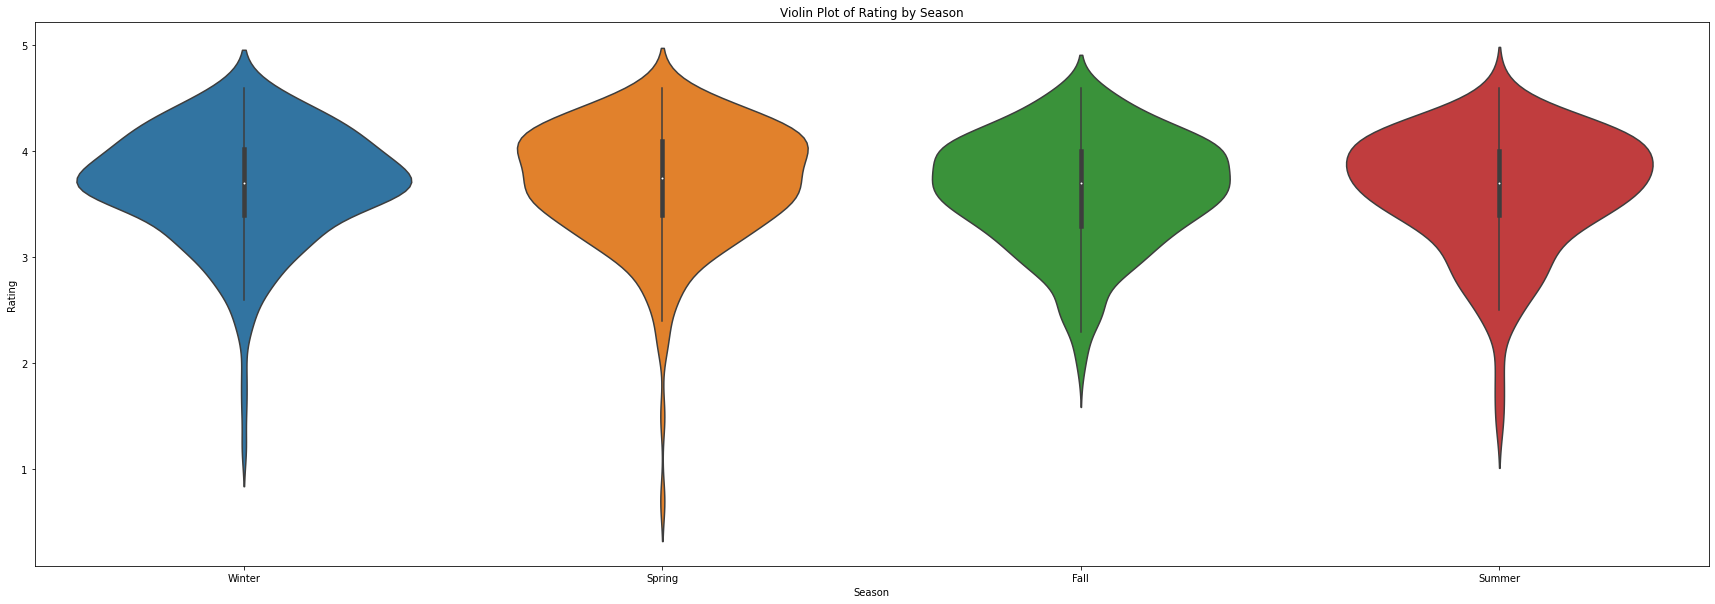

In [40]:
### SEASON & RATING

plt.figure(figsize = (30, 10))

sns.violinplot(x = 'Season', y = 'Rating', data = games)

plt.title('Violin Plot of Rating by Season')

plt.xlabel('Season')

plt.ylabel('Rating')

plt.show()

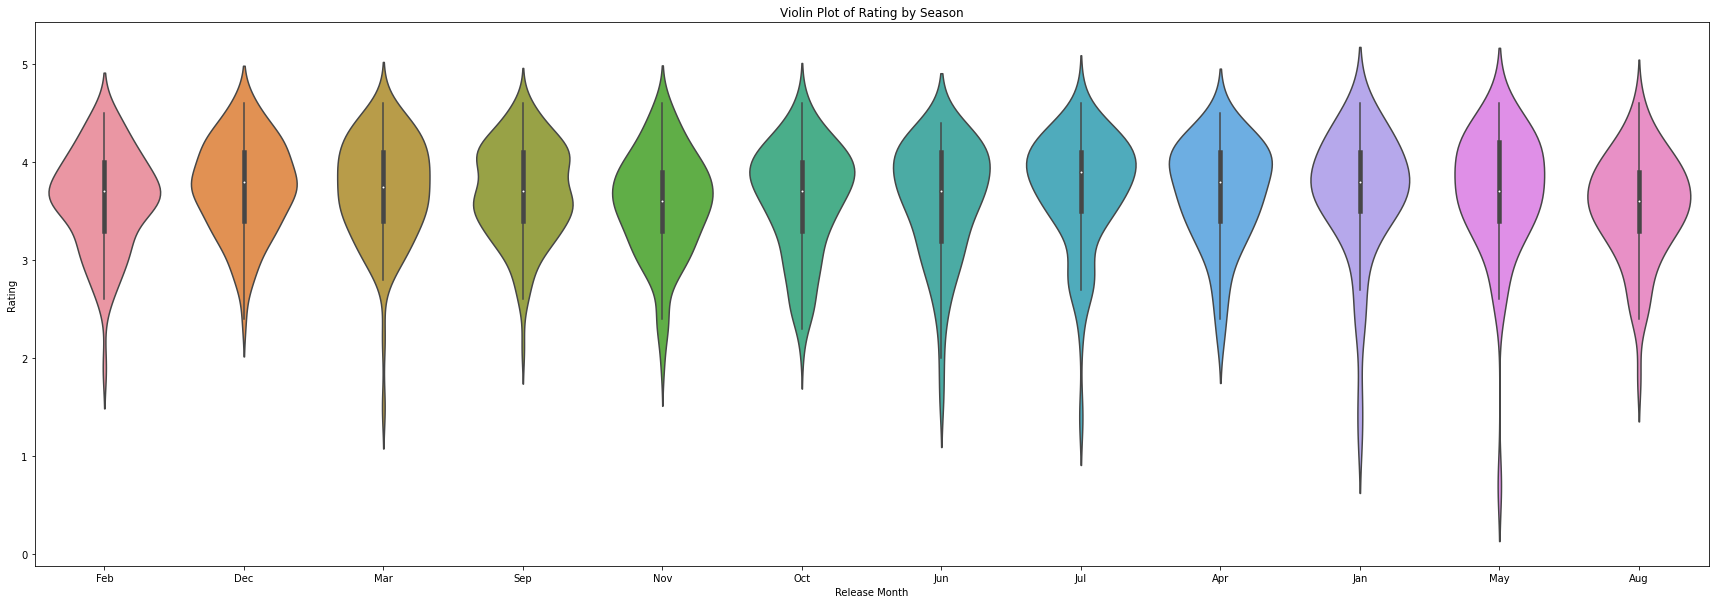

In [41]:
### MONTH & RATING

plt.figure(figsize = (30, 10))

sns.violinplot(x = 'Release Month', y = 'Rating', data = games)

plt.title('Violin Plot of Rating by Season')

plt.xlabel('Release Month')

plt.ylabel('Rating')

plt.show()

In [42]:
### TEAM + GENRE & RATING

# Explode dataframes because need to separate the lists

genres_exploded = games.explode('Genres')
team_exploded = games.explode('Team')

In [43]:
# Top 10 genres & teams

top_10_genres = sorted(genres_dict, key = genres_dict.get, reverse = True)[:10]
top_10_teams = sorted(team_dict, key = team_dict.get, reverse = True)[:10]

# Top 10 team and genre exploded dataframe

top_10_genres_exploded = genres_exploded[genres_exploded['Genres'].isin(top_10_genres)]
top_10_team_exploded = team_exploded[team_exploded['Team'].isin(top_10_teams)]

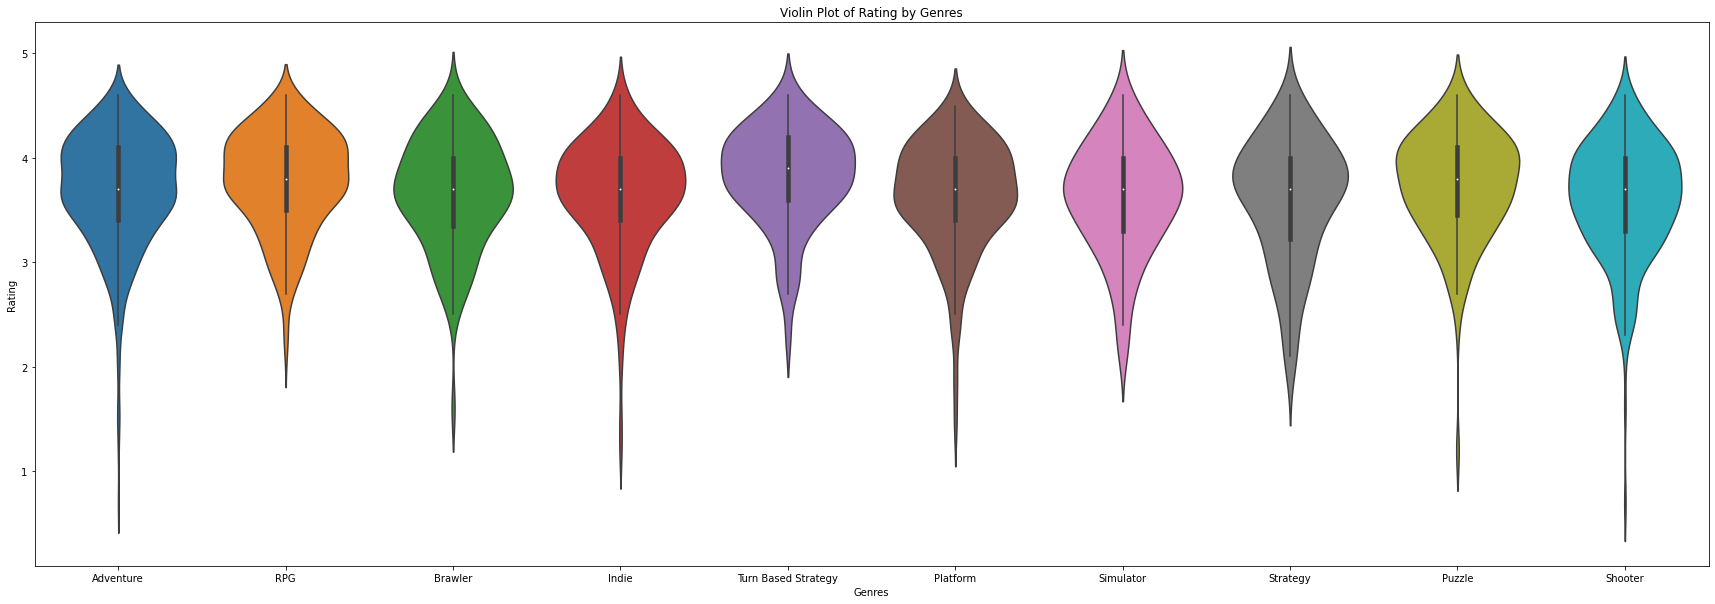

In [44]:
# Genres & Rating

plt.figure(figsize = (30, 10))

sns.violinplot(x = 'Genres', y = 'Rating', data = top_10_genres_exploded)

plt.title('Violin Plot of Rating by Genres')

plt.xlabel('Genres')

plt.ylabel('Rating')

plt.show()

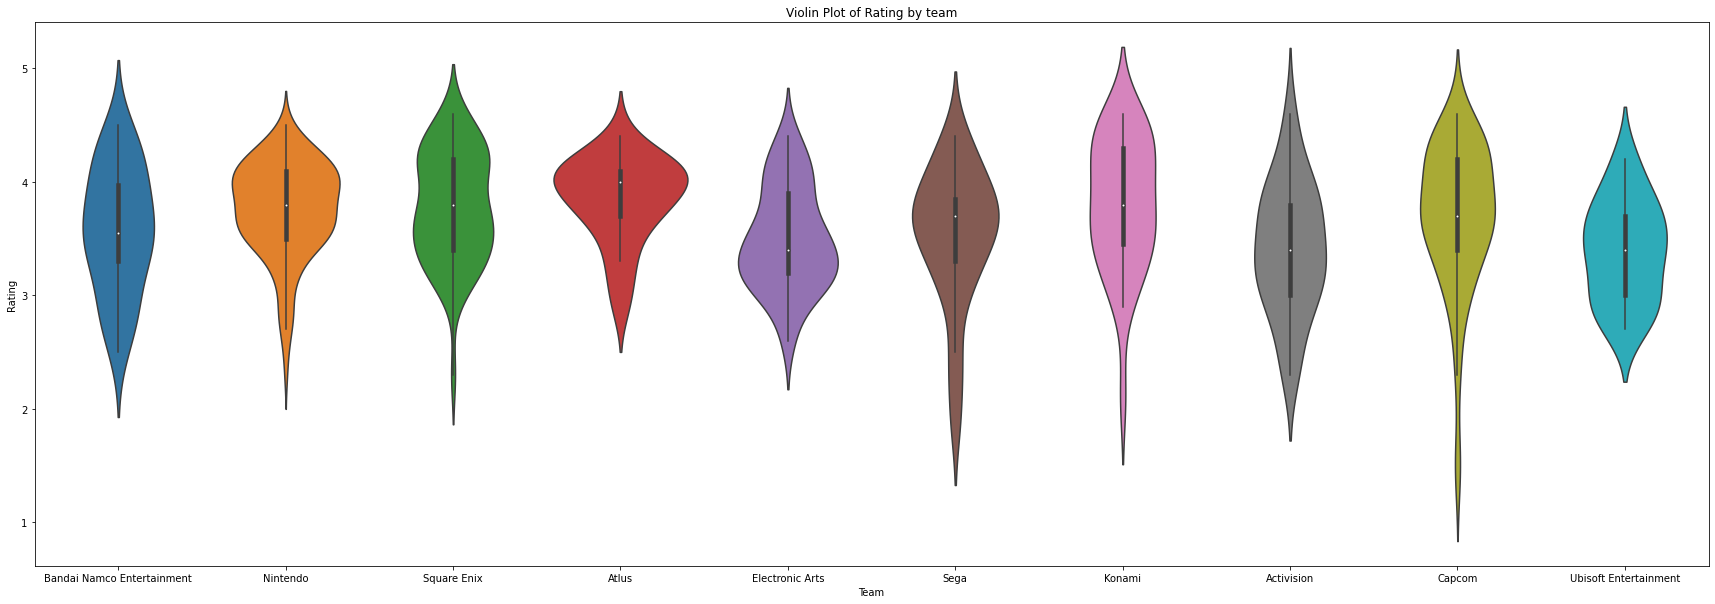

In [45]:
# Team & Rating

plt.figure(figsize = (30, 10))

sns.violinplot(x = 'Team', y = 'Rating', data = top_10_team_exploded)

plt.title('Violin Plot of Rating by team')

plt.xlabel('Team')

plt.ylabel('Rating')

plt.show()

### Word Analysis

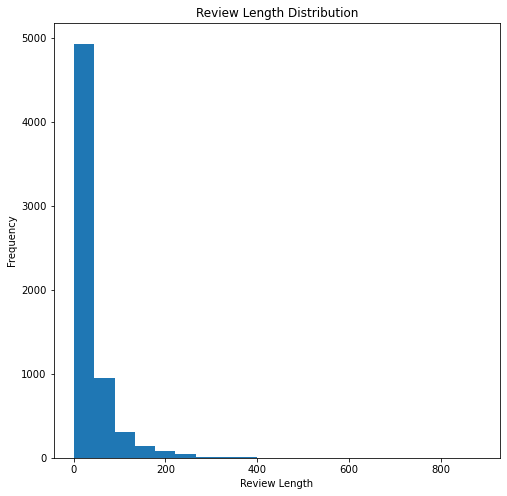

In [46]:
# Review Length Distribution All Games

plt.figure(figsize = (8, 8))

review_lengths = games_words['Reviews'].apply(lambda x: [len(review.split()) for review in x])

review_lengths_merged = [length for sublist in review_lengths.tolist() for length in sublist]

plt.hist(review_lengths_merged, bins = 20)

plt.title('Review Length Distribution')

plt.xlabel('Review Length')

plt.ylabel('Frequency')

plt.show()

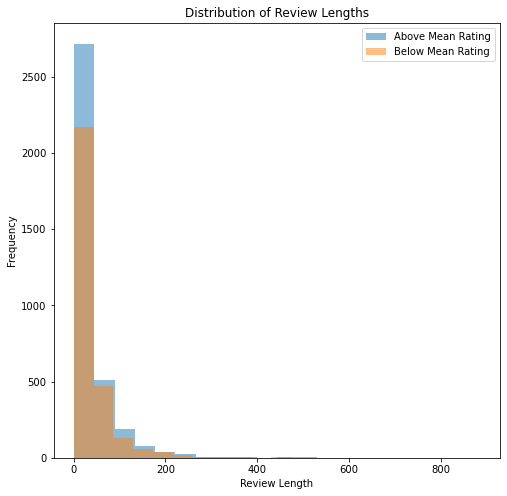

In [47]:
# Review Length Distribution Top Games

plt.figure(figsize = (8, 8))

mean_rating = games_words['Rating'].mean()

# Dataframe games above & below mean

above_mean = games_words[games_words['Rating'] > mean_rating]
below_mean = games_words[games_words['Rating'] < mean_rating]

# Comparison of Review Length Distribution for Above & Below Mean Games

above_mean_review_lengths = above_mean['Reviews'].apply(lambda x: [len(review.split()) for review in x])
below_mean_review_lengths = below_mean['Reviews'].apply(lambda x: [len(review.split()) for review in x])

above_mean_review_lengths_merged = [length for sublist in above_mean_review_lengths.tolist() for length in sublist]
below_mean_review_lengths_merged = [length for sublist in below_mean_review_lengths.tolist() for length in sublist]

plt.hist(above_mean_review_lengths_merged, bins = 20, alpha = 0.5, label = 'Above Mean Rating')
plt.hist(below_mean_review_lengths_merged, bins = 20, alpha = 0.5, label = 'Below Mean Rating')

plt.title('Distribution of Review Lengths')

plt.xlabel('Review Length')

plt.ylabel('Frequency')

plt.legend()

plt.show()

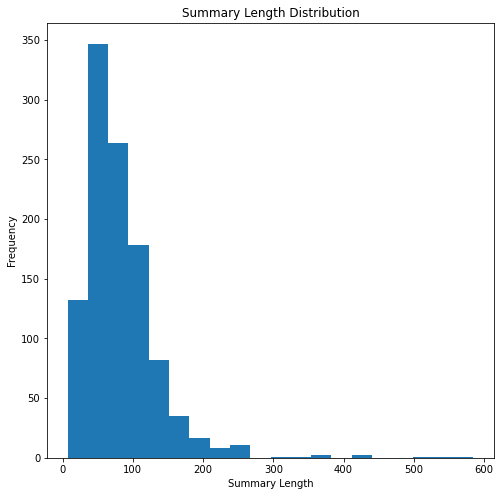

In [48]:
# Summary all games

plt.figure(figsize = (8, 8))

summary_lengths = games_words['Summary'].apply(lambda x: len(x.split()))

plt.hist(summary_lengths, bins=20)

plt.title('Summary Length Distribution')

plt.xlabel('Summary Length')

plt.ylabel('Frequency')

plt.show()

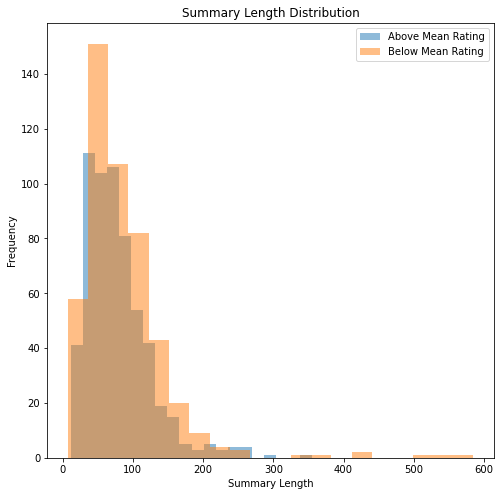

In [49]:
# Comparison of Summaries for Above Mean Games vs Below Mean Games

plt.figure(figsize = (8, 8))

above_mean_summary_lengths = above_mean['Summary'].apply(lambda x: len(x.split()))
below_mean_summary_lengths = below_mean['Summary'].apply(lambda x: len(x.split()))

plt.hist(above_mean_summary_lengths, bins = 20, alpha = 0.5, label = 'Above Mean Rating')
plt.hist(below_mean_summary_lengths, bins = 20, alpha = 0.5, label = 'Below Mean Rating')

plt.title('Summary Length Distribution')

plt.xlabel('Summary Length')

plt.ylabel('Frequency')

plt.legend()

plt.show()

In [50]:
# Download NLTK stopwords list

nltk.download('stopwords')

all_reviews_list = [review for sublist in games_words['Reviews'] if isinstance(sublist, list) for review in sublist]

# Combine all review strings into a single string

all_reviews_str = ' '.join(review for review in all_reviews_list)

# Split the combined string into words

words = all_reviews_str.split()

# Get stopwords from nltk & filter

stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.lower() not in stop_words]

# Count the occurrences of each non-stopword

word_counts = Counter(filtered_words)

# Get the top 10 most common non-stopwords
top_words = word_counts.most_common(10)

top_words_df = pd.DataFrame(top_words, columns = ['Word', 'Frequency'])

print(top_words_df)

     Word  Frequency
0    game       3156
1    like       1083
2      de        986
3     que        929
4  really        898
5     one        735
6       e        691
7     fun        681
8    good        644
9   games        635


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidpaquette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Correlation Matrix

<AxesSubplot:>

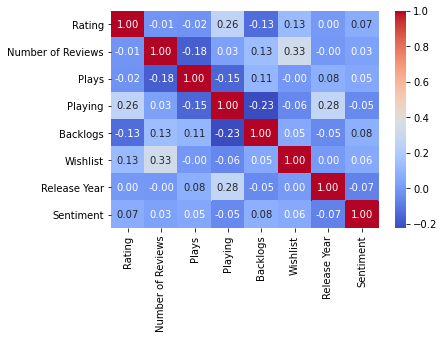

In [51]:
#plot the pearson correlation of the numeric variables in the dataset 
corr_matrix = games.corr()
sns.heatmap(corr_matrix, annot = True, cmap ='coolwarm', fmt =".2f")

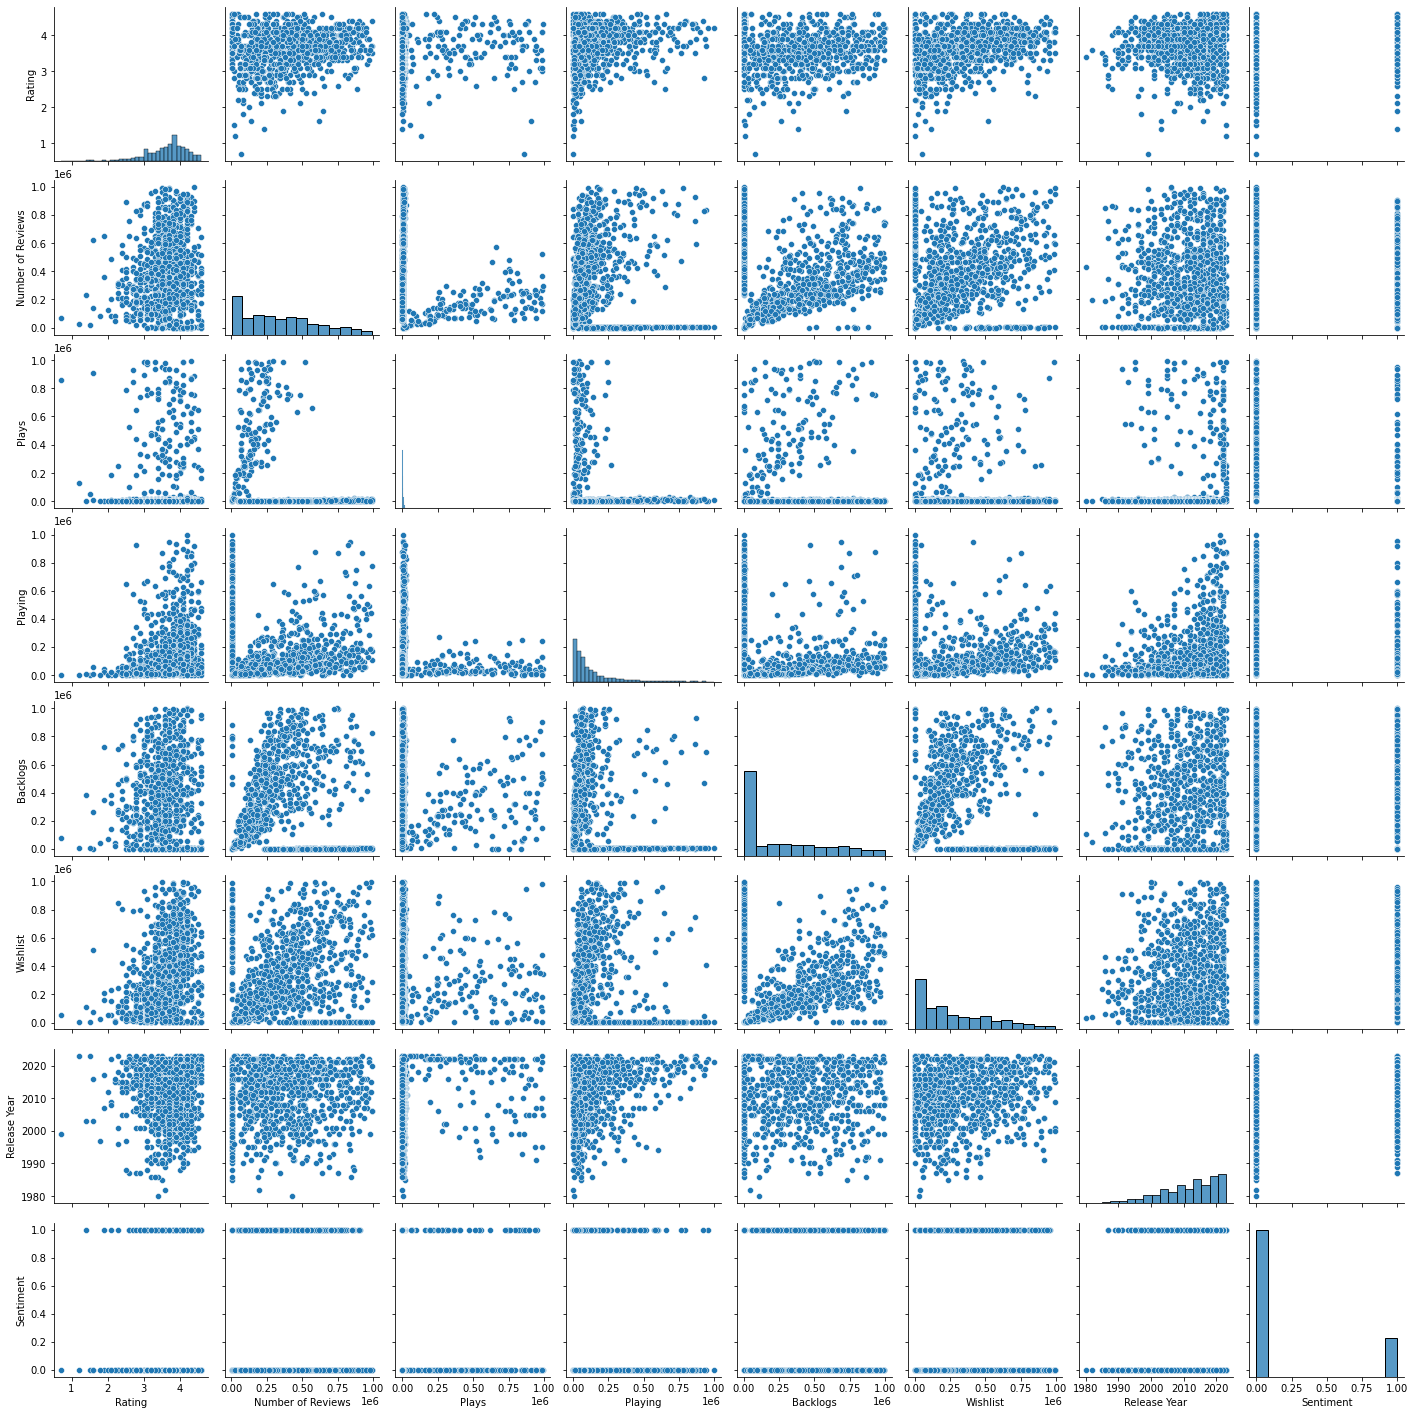

In [52]:
# constructing pair plots for seeing the distirbution of one and the relationship of two variables for all the variables
p = sns.pairplot(games)
# the lack of clear direction and too wide scattering of the data points for all the pair plots visualizes the very low 
# correlation observed in the pearson correlation heat map
# in addition there are no variables with normal or even unskewed distributions 

In [53]:
# Scaling the numeric variables using a standard scaler (for achiving mean = 0 and SD = 1) since they are two magniutdes 
# larger than the dummy variables

scaling_columns = ['Playing', 'Backlogs', 'Wishlist', 'Plays', 'Number of Reviews']
 
st_sc = StandardScaler()
games[scaling_columns] = st_sc.fit_transform(games[scaling_columns])

In [54]:
games.head()

,Title,Team,Rating,Number of Reviews,Genres,Reviews,Plays,Playing,Backlogs,Wishlist,Season,Release Month,Release Year,Sentiment
0,Elden Ring,"[Bandai Namco Entertainment, FromSoftware]",4.5,-1.255451,"[Adventure, RPG]","[""The first playthrough of elden ring is one o...",-0.280160,-0.775843,-0.878538,-1.090593,Winter,Feb,2022,0
1,Hades,[Supergiant Games],4.3,-1.259193,"[Adventure, Brawler, Indie, RPG]",['convinced this is a roguelike for people who...,-0.260362,-0.779174,-0.872907,-1.095110,Winter,Dec,2019,1
2,The Legend of Zelda: Breath of the Wild,"[Nintendo, Nintendo EPD Production Group No. 3]",4.4,-1.253955,"[Adventure, RPG]",['This game is the game (that is not CS:GO) th...,-0.215817,-0.783060,-0.877213,-1.098873,Spring,Mar,2017,0
3,Undertale,"[tobyfox, 8-4]",4.2,-1.256948,"[Adventure, Indie, RPG, Turn Based Strategy]",['soundtrack is tied for #1 with nier automata...,-0.225716,2.972678,-0.877544,-1.101885,Fall,Sep,2015,0
4,Hollow Knight,[Team Cherry],4.4,-1.258819,"[Adventure, Indie, Platform]","[""this games worldbuilding is incredible, with...",-0.260362,-0.783615,-0.866282,-1.100003,Winter,Feb,2017,1


## Model Building & Testing

Despite more than suboptimal correlation between the variables (espceically towards our dependent varaible "Rating") 
 we tried to build a regression model to try out the workings of this final step in the process

In [55]:
# Assign the dependent variable for the regression
y = games["Rating"]

In [56]:
# Exclude all columns that are not interesting predictiors, not applicable (Times listed has perfect correlation with Number of Reviews) or were converted into dummy variables  
X = games.drop(["Title", "Rating", "Reviews", "Team"], axis=1)

# Because Genres is a list, has become unhashable as a dummy - need to explode the dataset on Genres and tranform it
# into a dummt variable
genres_dummies = games['Genres'].explode().str.get_dummies().sum(level = 0)

# Combine new dummy variable with remaining data
X = pd.concat([games.drop(["Title", "Rating", "Reviews", "Team", "Genres"], axis=1), genres_dummies], axis=1)
X = pd.get_dummies(X, columns=["Release Month", "Season"], drop_first = True)

In [57]:
# Splitting the data into the training and test set with dependent and independent variables
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Create and train the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [59]:
# Make predictions on the test data
y_pred = lin_model.predict(X_test)

In [60]:
# Mean Squared Error (MSE) to evaluate the tested model
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

0.24665462891226048


In [61]:
# Fit a least square regression model to get coefficients and their p-values
X = sm.add_constant(X) #incuding a constant to account for bias
lin_model = sm.OLS(y, X).fit()

# Get the summary results
summary = lin_model.summary()
print(summary)

# The really low R-squared shows that the proportion of Ratings variance explained by the model built on our 
# independent variables is very low

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     5.491
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           3.99e-24
Time:                        19:37:43   Log-Likelihood:                -759.21
No. Observations:                1083   AIC:                             1602.
Df Residuals:                    1041   BIC:                             1812.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.0979    

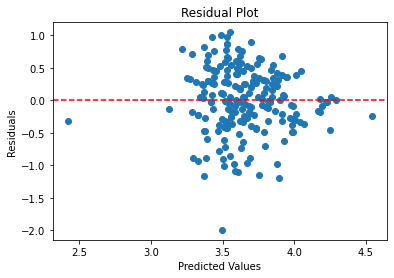

In [62]:
# Calculate the residuals
residuals = y_test - y_pred

# Create a residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

## Lasso Model

Linear regression didn't prove to be a could model predictor of video game ratings. Attempt to see if Lasso regression works better.

In [63]:
# Create and train the Lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Make predictions on the test set
y_pred1 = lasso.predict(X_test)

# Evaluate
MSE1 = mean_squared_error(y_test, y_pred1)

#Overall, lasso regression produces a worse MSE than linear regression
print(MSE1)

0.2823071817896415
